In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [2]:
df = pd.read_csv('data/df_regression.csv')


In [3]:
df.columns

Index(['id_istat', 'id_comune', 'Provincia', 'Regione',
       'Ripartizione Geografica', 'id_catastale', 'Indice di spopolamento',
       'Codice regione', 'Capoluogo_enc', 'Codice comuni',
       'Indice di occupazione', 'Indice disoccupazione', 'Fascia',
       'Descrizione Zona', 'Sottofascia Zona', 'id_univoco',
       'Costo Minimo alla Vendita', 'Costo Massimo alla Vendita',
       'Media Costo alla Vendita', 'Costo Minimo alla Locazione',
       'Costo Massimo alla Locazione', 'Media Costo alla Locazione',
       'Cod. Circoscrizione Turistica',
       'Tipo di località_Altri comuni non altrimenti classificati',
       'Tipo di località_Capoluogo senza specifici interessi turistici',
       'Tipo di località_Città d'Arte', 'Tipo di località_Località collinari',
       'Tipo di località_Località lacuali', 'Tipo di località_Località marine',
       'Tipo di località_Località montane',
       'Tipo di località_Località religiose',
       'Tipo di località_Località termali', 'PC_Ec

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21513 entries, 0 to 21512
Data columns (total 52 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   id_istat                                                         21513 non-null  int64  
 1   id_comune                                                        21512 non-null  object 
 2   Provincia                                                        21513 non-null  object 
 3   Regione                                                          21513 non-null  object 
 4   Ripartizione Geografica                                          21513 non-null  object 
 5   id_catastale                                                     21513 non-null  object 
 6   Indice di spopolamento                                           21512 non-null  float64
 7   Codice regione                          

In [5]:
# Creating the x_vars list 
x_vars = ["Indice di spopolamento","Indice di occupazione",
          "Indice disoccupazione","Tipo di località_Altri comuni non altrimenti classificati",
          "Tipo di località_Capoluogo senza specifici interessi turistici","Tipo di località_Città d\'Arte",
          "Tipo di località_Località collinari","Tipo di località_Località lacuali",
          "Tipo di località_Località marine","Tipo di località_Località montane",
          "Tipo di località_Località religiose","Tipo di località_Località termali", 
          "PC_Economica","PC_Turistica_1","PC_Turistica_2", "PC_Turistica_3", "PC_Turistica_4", 
          "PC_Turistica_5", "PC_Turistica_6", "PC_Turistica_7", "PC_Turistica_8", "PC_Turistica_9", 
          "PC_Turistica_10", "PC_Turistica_11", "PC_Turistica_12", "Macroarea_Isole", "Macroarea_Nord", 
          "Macroarea_Sud","Descrizione_Tipologia_di_Immobile_Abitazioni_di_tipo_economico", 
          "Descrizione_Tipologia_di_Immobile_Abitazioni_signorili", 
          "Descrizione_Tipologia_di_Immobile_Abitazioni_tipiche_dei_luoghi",
          "Descrizione_Tipologia_di_Immobile_Ville_e_Villini"]


In [6]:
# Identifica automaticamente le colonne PCA e non-PCA
pca_columns = [col for col in x_vars if col.startswith("PC_")]
non_pca_columns = [col for col in x_vars if not col.startswith("PC_")]

# Crea un DataFrame con i dati originali
X = df[x_vars]  # Questo contiene TUTTE le colonne in x_vars
y = df["Media Costo alla Vendita"]

# Inizializza lo StandardScaler
scaler = StandardScaler()

# Crea una copia di X per i dati standardizzati
X_scaled = X.copy()  # X_scaled ha TUTTE le colonne originali

# Standardizza SOLO le colonne non-PCA, mantenendole in X_scaled
X_scaled[non_pca_columns] = scaler.fit_transform(X[non_pca_columns])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# Hyperparameters optimization

In [8]:
# Funzione per definire il modello con iperparametri variabili
def build_model(hp):
    model = Sequential()
    # Primo livello
    model.add(Dense(units=hp.Fixed("units_1", 256),
                    activation='relu', input_shape=(X_train.shape[1],)))
    # secondo livello
    model.add(Dense(units=hp.Int("units_2", min_value=128, max_value=256, step=32),
                    activation="relu", input_shape=(X_train.shape[1],)))
    # terzo livello opzionale
    if hp.Boolean("add_third_layer"):
        model.add(Dense(units=hp.Int("units_3", min_value=32, max_value=256, step=32),
                        activation="relu"))
    # Livello di output
    model.add(Dense(1))  # Nessuna attivazione per regressione
    # Compilazione del modello
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])),
        loss="mse",
        metrics=["mae"]
    )
    return model


In [9]:
# Creazione del tuner per cercare i migliori iperparametri
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='my_tuner',
    project_name='house_price_prediction'
)

# Callback per interrompere l'addestramento se non ci sono miglioramenti
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Ricerca degli iperparametri migliori
tuner.search(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping])


Trial 254 Complete [00h 00m 42s]
val_loss: 791274.625

Best val_loss So Far: 791274.4375
Total elapsed time: 01h 05m 14s


In [15]:
# Mostrare i migliori iperparametri trovati
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Migliori iperparametri trovati:")
print(f"- Unità nel primo livello: {best_hps.get("units_1")}")
print(f"- Unità nel secondo livello: {best_hps.get("units_2")}")
if best_hps.get("add_third_layer"):
    print(f"- Unità nel terzo livello: {best_hps.get("units_3")}")
print(f"- Learning rate: {best_hps.get("learning_rate")}")



Migliori iperparametri trovati:
- Unità nel primo livello: 256
- Unità nel secondo livello: 192
- Unità nel terzo livello: 192
- Learning rate: 0.001


In [11]:
# Costruzione del modello con i migliori iperparametri
best_model = tuner.hypermodel.build(best_hps)
# Addestramento del modello con i migliori iperparametri
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[early_stopping])


Epoch 1/50


c:\Users\Acer\OneDrive\Desktop\DevlHope\Team4 - Immobili\repo\real_estate_predictive_model\lucia.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1477484.1250 - mae: 870.6282 - val_loss: 1629768.0000 - val_mae: 919.5494
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1143043.7500 - mae: 685.4458 - val_loss: 791318.5625 - val_mae: 599.3151
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 775012.0000 - mae: 594.0974 - val_loss: 792450.6250 - val_mae: 592.2325
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 762310.8750 - mae: 585.6363 - val_loss: 791538.3125 - val_mae: 605.6964
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 770266.8125 - mae: 590.7717 - val_loss: 791316.2500 - val_mae: 599.3729
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 786555.5625 - mae: 592.5531 - val_loss: 791302.5000 - val_mae: 602.5479
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 752538.1250 - mae: 585.3355 - val_loss: 791276.0625 - val_mae: 601.4460
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 785220.3750 - mae: 589.2

In [12]:
y_pred = best_model.predict(X_test)
# Calcolo delle metriche
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error (MAE): 613.0939532046592
Mean Squared Error (MSE): 867827.4247219701
Root Mean Squared Error (RMSE): 931.572554727741
R-squared (R2): -0.00014265593750040217


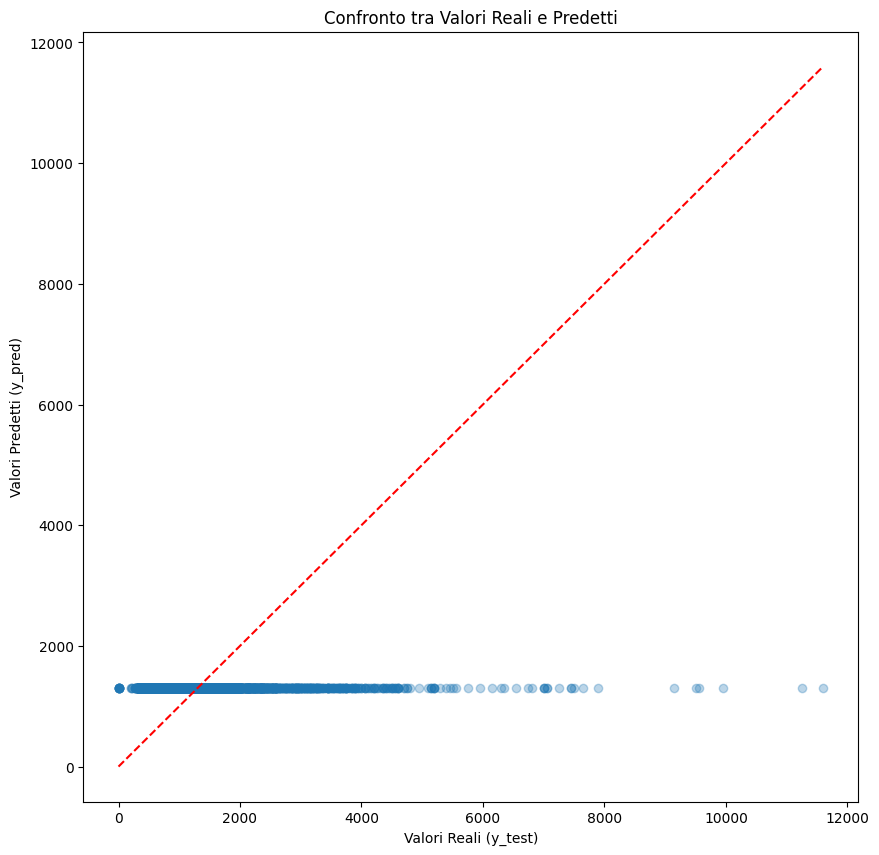

In [13]:
# Grafico di confronto tra valori reali e predetti
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valori Reali (y_test)")
plt.ylabel("Valori Predetti (y_pred)")
plt.title("Confronto tra Valori Reali e Predetti")
plt.show()